# Capstone Object Detection

Let's get started!

In [1]:
import tensorflow as tf
import numpy as np
from PIL import Image
from PIL import ImageDraw
from PIL import ImageColor
from PIL import ImageFont
import matplotlib.pyplot as plt
import time
import cv2

%matplotlib inline
plt.style.use('ggplot')

/home/m/miniconda3/envs/OD/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## *MobileNet* SSD

In this section you'll use a pretrained *MobileNet* [SSD](https://arxiv.org/abs/1512.02325) model to perform object detection. You can download the *MobileNet* SSD and other models from the [TensorFlow detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md). [Paper](https://arxiv.org/abs/1611.10012) describing comparing several object detection models.

Alright, let's get into SSD!

### Single Shot Detection (SSD)

Many previous works in object detection involve more than one training phase. For example, the [Faster-RCNN](https://arxiv.org/abs/1506.01497) architecture first trains a Region Proposal Network (RPN) which decides which regions of the image are worth drawing a box around. RPN is then merged with a pretrained model for classification (classifies the regions). The image below is an RPN:

![Faster-RCNN Visual](./assets/faster-rcnn.png)

The SSD architecture is a single convolutional network which learns to predict bounding box locations and classify the locations in one pass. Put differently, SSD can be trained end to end while Faster-RCNN cannot. The SSD architecture consists of a base network followed by several convolutional layers: 

![SSD Visual](./assets/ssd_architecture.png)

**NOTE:** In this lab the base network is a MobileNet (instead of VGG16.)

#### Detecting Boxes

SSD operates on feature maps to predict bounding box locations. Recall a feature map is of size $D_f * D_f * M$. For each feature map location $k$ bounding boxes are predicted. Each bounding box carries with it the following information:

* 4 corner bounding box **offset** locations $(cx, cy, w, h)$
* $C$ class probabilities $(c_1, c_2, ..., c_p)$

SSD **does not** predict the shape of the box, rather just where the box is. The $k$ bounding boxes each have a predetermined shape. This is illustrated in the figure below:

![](./assets/ssd_feature_maps.png)

The shapes are set prior to actual training. For example, In figure (c) in the above picture there are 4 boxes, meaning $k$ = 4.

###  SSD Summary

* Starts from a base model pretrained on ImageNet. 
* The base model is extended by several convolutional layers.
* Each feature map is used to predict bounding boxes. Diversity in feature map size allows object detection at different resolutions.
* Boxes are filtered by IoU metrics and hard negative mining.
* Loss is a combination of classification (softmax) and dectection (smooth L1)
* Model can be trained end to end.

# Object Detection Inference

In this part of the lab you'll detect objects using pretrained object detection models. You can download the latest pretrained models from the model zoo, although do note that you may need a newer version of TensorFlow (such as v1.8) in order to use the newest models.

We are providing the download links for the below noted files to ensure compatibility between the included environment file and the models.

[SSD_Mobilenet 11.6.17 version](http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_coco_11_06_2017.tar.gz)

[RFCN_ResNet101 11.6.17 version](http://download.tensorflow.org/models/object_detection/rfcn_resnet101_coco_11_06_2017.tar.gz)

[Faster_RCNN_Inception_ResNet 11.6.17 version](http://download.tensorflow.org/models/object_detection/faster_rcnn_inception_resnet_v2_atrous_coco_11_06_2017.tar.gz)

Make sure to extract these files prior to continuing!

In [3]:
# Frozen inference graph files. NOTE: change the path to where you saved the models.
SSD_INCEPTION_RETRAINED_REAL = './models/ssd_inception_v2_4tzones_bosch_real_100000_steps/frozen_inference_graph.pb'
SSD_INCEPTION_RETRAINED_SIM = './models/ssd_inception_v2_alex_sim_20000_steps/frozen_inference_graph.pb'

Below are utility functions. The main purpose of these is to draw the bounding boxes back onto the original image.

In [28]:
#
# Utility funcs
#

def filter_boxes(min_score, boxes, scores, classes):
    """Return boxes with a confidence >= `min_score`"""
    n = len(classes)
    idxs = []
    for i in range(n):
        if scores[i] >= min_score:
            idxs.append(i)
    
    filtered_boxes = boxes[idxs, ...]
    filtered_scores = scores[idxs, ...]
    filtered_classes = classes[idxs, ...]
    return filtered_boxes, filtered_scores, filtered_classes

def to_image_coords(boxes, height, width):
    """
    The original box coordinate output is normalized, i.e [0, 1].
    
    This converts it back to the original coordinate based on the image
    size.
    """
    box_coords = np.zeros_like(boxes)
    box_coords[:, 0] = boxes[:, 0] * height
    box_coords[:, 1] = boxes[:, 1] * width
    box_coords[:, 2] = boxes[:, 2] * height
    box_coords[:, 3] = boxes[:, 3] * width
    
    return box_coords

def draw_boxes(image, boxes, classes, scores, thickness=4):
    """Draw bounding boxes on the image"""
    # get drawing context
    draw = ImageDraw.Draw(image)
    
    for i in range(len(boxes)):
        bot, left, top, right = boxes[i, ...] #ymax, xmin, ymin, xmax
        class_id = int(classes[i])
        
        if class_id == 1:
            color = (0,255,0)
            class_name = "GREEN"
        if class_id == 2:
            color = (255,0,0)
            class_name = "RED"
        if class_id == 3:
            color = (255,255,0)
            class_name = "YELLOW"
        if class_id == 4:
            color = (0,0,0)
            class_name = "OFF"
        
        #draw bounding box
        draw.line([(left, top), (left, bot), (right, bot), (right, top), (left, top)], width=thickness, fill=color)
        
        # set font, text and get text size
        font = ImageFont.truetype('FreeSansBold.ttf', 30)
        text = class_name+" | "+str("{:.0f}".format(scores[i]*100))+"%"
        x, y = font.getsize(text)
        
        # draw textbox
        draw.rectangle([(right+15, bot), (right+15+x, bot+y)], fill=color)
        
        # draw text
        draw.text((right+15, bot), text, font=font, fill=(0,0,0))
        
def load_graph(graph_file):
    """Loads a frozen inference graph"""
    graph = tf.Graph()
    with graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(graph_file, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    return graph

Below we load the graph and extract the relevant tensors using [`get_tensor_by_name`](https://www.tensorflow.org/api_docs/python/tf/Graph#get_tensor_by_name). These tensors reflect the input and outputs of the graph, or at least the ones we care about for detecting objects.

In [32]:
detection_graph = load_graph(SSD_INCEPTION_RETRAINED_SIM)
#detection_graph = load_graph(SSD_INCEPTION_RETRAINED_REAL)

# Get Tensors
image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')

 # Create session
sess = tf.Session(graph=detection_graph)

Run detection and classification on a sample image.

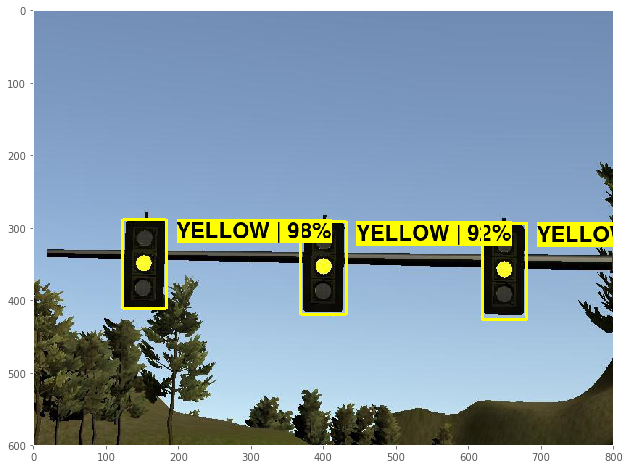

In [38]:
# Load a sample image.
image = Image.open('test/images/sim/2.jpg')
#image = image.resize((300,300))
image_np = np.expand_dims(np.asarray(image, dtype=np.uint8), 0)
             
# Actual detection.
(boxes, scores, classes) = sess.run([detection_boxes, detection_scores, detection_classes], 
                                        feed_dict={image_tensor: image_np})

# Remove unnecessary dimensions
boxes = np.squeeze(boxes)
scores = np.squeeze(scores)
classes = np.squeeze(classes)

confidence_cutoff = 0.5
# Filter boxes with a confidence score less than `confidence_cutoff`
boxes, scores, classes = filter_boxes(confidence_cutoff, boxes, scores, classes)

# The current box coordinates are normalized to a range between 0 and 1.
# This converts the coordinates to actual location on the image.
width, height = image.size
box_coords = to_image_coords(boxes, height, width)

# Each class with be represented by a differently colored box
draw_boxes(image, box_coords, classes, scores)

plt.figure(figsize=(12, 8))
plt.grid(False)
plt.imshow(image)
plt.show()

## Timing Detection

The model zoo comes with a variety of models, each its benefits and costs. Below you'll time some of these models. The general tradeoff being sacrificing model accuracy for seconds per frame (SPF).

In [7]:
def time_detection(sess, img_height, img_width, runs=10):
    # warmup
    gen_image = np.uint8(np.random.randn(1, img_height, img_width, 3))
    sess.run([detection_boxes, detection_scores, detection_classes], feed_dict={image_tensor: gen_image})
    
    times = np.zeros(runs)
    for i in range(runs):
        t0 = time.time()
        sess.run([detection_boxes, detection_scores, detection_classes], feed_dict={image_tensor: image_np})
        t1 = time.time()
        times[i] = (t1 - t0) * 1000
    return times

In [8]:
times = time_detection(sess, height, width, runs=10)

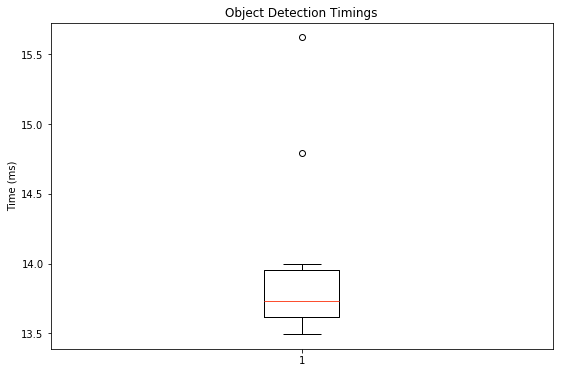

In [9]:
# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)
plt.title("Object Detection Timings")
plt.ylabel("Time (ms)")

# Create the boxplot
plt.style.use('fivethirtyeight')
bp = ax.boxplot(times)

### Exercise 4 - Model Tradeoffs

Download a few models from the [model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) and compare the timings.

## Detection on a Video

Finally run your pipeline on [this short video](https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/advanced_deep_learning/driving.mp4).

In [11]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [12]:
HTML("""
<video width="960" height="600" controls>
  <source src="{0}" type="video/mp4">
</video>
""".format('ourbag.mp4'))

### Exercise 5 - Object Detection on a Video

Run an object detection pipeline on the above clip.

In [13]:
clip = VideoFileClip('test/videos/ourbag.mp4')#.subclip((1,15),(1,20))

In [17]:
# TODO: Complete this function.
# The input is an NumPy array.
# The output should also be a NumPy array.
def pipeline(img):
    image = Image.fromarray(img)
    #image = image.resize((300,300))
    image_np = np.expand_dims(np.asarray(img, dtype=np.uint8), 0)
                    
    # Actual detection.
    (boxes, scores, classes) = sess.run([detection_boxes, detection_scores, detection_classes], 
                                        feed_dict={image_tensor: image_np})

    # Remove unnecessary dimensions
    boxes = np.squeeze(boxes)
    scores = np.squeeze(scores)
    classes = np.squeeze(classes)

    confidence_cutoff = 0.5
    # Filter boxes with a confidence score less than `confidence_cutoff`
    boxes, scores, classes = filter_boxes(confidence_cutoff, boxes, scores, classes)

    # The current box coordinates are normalized to a range between 0 and 1.
    # This converts the coordinates actual location on the image.
    width, height = image.size
    box_coords = to_image_coords(boxes, height, width)

    # Each class with be represented by a differently colored box
    draw_boxes(image, box_coords, classes, scores)

    #plt.figure(figsize=(12, 8))
    image = np.asarray(image, dtype=np.uint8)
    return image

In [18]:
new_clip = clip.fl_image(pipeline)
    
# write to file
new_clip.write_videofile('result.mp4', audio=False)

[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4


100%|█████████▉| 544/545 [00:08<00:00, 61.44it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 



In [19]:
HTML("""
<video width="960" height="600" controls>
  <source src="{0}" type="video/mp4">
</video>
""".format('result.mp4'))

## Further Exploration

Some ideas to take things further:

* Finetune the model on a new dataset more relevant to autonomous vehicles. Instead of loading the frozen inference graph you'll load the checkpoint.
* Optimize the model and get the FPS as low as possible.
* Build your own detector. There are several base model pretrained on ImageNet you can choose from. [Keras](https://keras.io/applications/) is probably the quickest way to get setup in this regard.
